<a href="https://colab.research.google.com/github/KNL1979/DS807/blob/main/Q3_1_CNN_model_resized_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install wandb

In [1]:
!pip install wandb -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


# Import libraries

In [2]:
import os
import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, Reshape, BatchNormalization, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Set directory

In [4]:
%cd '/content/gdrive/My Drive/AML_Exam/problem1/'

/content/gdrive/My Drive/AML_Exam/problem1


# Load data

In [5]:
# Load features
X_train_original = np.load('AE/datasets/X_train_new.npy')
X_val_original = np.load('AE/datasets/X_val_new.npy')
X_test_original = np.load('AE/datasets/X_test_new.npy')

# Load labels
y_train = np.load('y_train_new.npy')
y_val = np.load('y_val_new.npy')
y_test = np.load('y_test_new.npy')

# Resize data

In [6]:
def resize_and_normalize_image(image):
    image = tf.image.resize(image, [32, 32])
    image = tf.image.rgb_to_grayscale(image)
    return image / 255.0

# Apply resize_and_normalize_image function to each set of images
X_train = np.array([resize_and_normalize_image(img) for img in X_train_original])
X_val = np.array([resize_and_normalize_image(img) for img in X_val_original])
X_test = np.array([resize_and_normalize_image(img) for img in X_test_original])

In [7]:
print("Original Image Shapes:")
print(X_train_original.shape, X_val_original.shape, X_test_original.shape)
print("Resized Image Shapes:")
print(X_train.shape, X_val.shape, X_test.shape)
print("Label Shapes:")
print(y_train.shape, y_val.shape, y_test.shape)

Original Image Shapes:
(55050, 96, 96, 3) (15729, 96, 96, 3) (7864, 96, 96, 3)
Resized Image Shapes:
(55050, 32, 32, 1) (15729, 32, 32, 1) (7864, 32, 32, 1)
Label Shapes:
(55050, 2) (15729, 2) (7864, 2)


# Is the dataset balanced?

In [8]:
print("Class distribution in training set:")
print(np.sum(y_train, axis=0))

print("\nClass distribution in validation set:")
print(np.sum(y_val, axis=0))

print("\nClass distribution in test set:")
print(np.sum(y_test, axis=0))

Class distribution in training set:
[27370. 27680.]

Class distribution in validation set:
[8008. 7721.]

Class distribution in test set:
[3931. 3933.]


# Show images

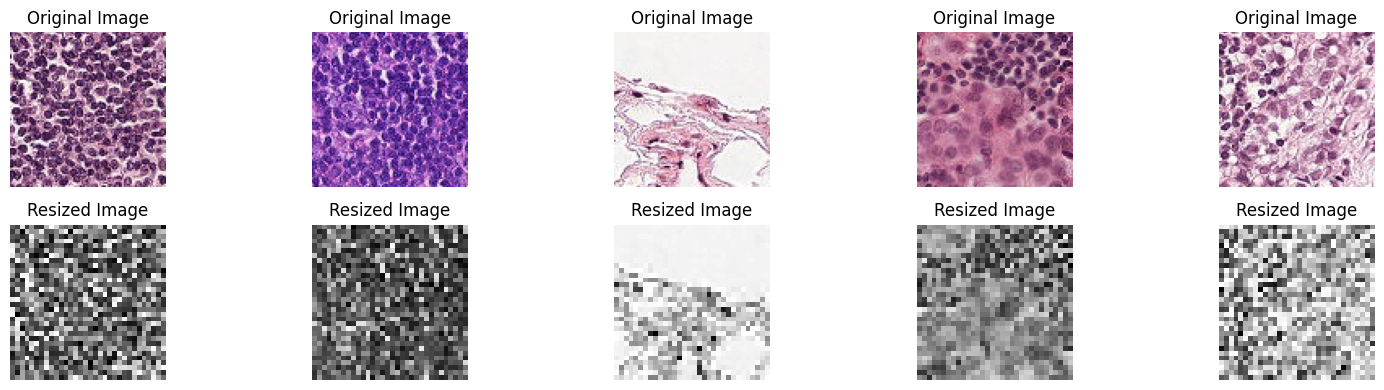

In [9]:
# Display 5 pairs of original and resized images from X_train
plt.figure(figsize=(16, 4))

for i in range(5):
    original_image = X_train_original[i]
    resized_image = X_train[i]

    # Original image
    plt.subplot(2, 5, i+1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Resized image
    plt.subplot(2, 5, i+6)
    plt.imshow(resized_image[:, :, 0],cmap='gray')
    plt.title("Resized Image")
    plt.axis("off")

plt.tight_layout()

plt.show()

# Setup wandb

In [47]:
## Here you need to supply your own wandb API key (if it has not been set by wandb login at prompt has not been used), project name and entity name.

os.environ["WANDB_API_KEY"]= '5133144760b6264ec0a9f8478f203eae1b18020c'

In [48]:
# Login to W&B (call this before any other W&B functions)
wandb.login()

wandb: Currently logged in as: kimlund1979 (coffeegang). Use `wandb login --relogin` to force relogin


True

In [49]:
# Sweep configuration
sweep_name = 'Kim_CNN_resize'
sweep_config = {
    'name': sweep_name,
    'method': 'random',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'batch_size': {'distribution': 'q_log_uniform_values', 'min': 16, 'max': 256},
        'dropout_conv': {'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},  # Dropout for Conv layers
        'dropout_dense': {'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},  # Dropout for Dense layers
        'learning_rate': {'distribution': 'log_uniform_values', 'min': 5e-6, 'max': 1e-4},
        'hidden_layer_size': {'values': [256, 512, 1024]},
        'hidden_layers': {'min': 2, 'max': 5},
        'filters': {'values': [16, 32, 64]},
        'kernel_size': {'values': [3, 5]}
    }
}

In [50]:
sweep_id = wandb.sweep(sweep_config, project="Kim_sweeps", entity='coffeegang')

Create sweep with ID: w44abky7
Sweep URL: https://wandb.ai/coffeegang/Kim_sweeps/sweeps/w44abky7


# Hyperparameter search, employing 'wandb'-sweep

In [51]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 50,
        'batch_size': 32,
        'learning_rate': 1e-3,
        'activation': 'relu',
        'optimizer': 'adam',
        'hidden_layer_size': 508,
        'dropout_conv': 0.2,
        'dropout_dense': 0.2,
        'hidden_layers': 3,
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Define the model architecture
    model = Sequential()

    # Set input shape
    model.add(Input(shape=(32, 32, 1)))

    for _ in range(config.hidden_layers):
        model.add(Conv2D(config.filters, config.kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, padding='same'))
        model.add(SpatialDropout2D(config.dropout_conv))

    # Flatten layer before the dense layers
    model.add(Flatten())

    # Dense layers for classification
    for _ in range(config.hidden_layers):
        model.add(Dense(config.hidden_layer_size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(config.dropout_dense))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    # Fit the model
    hist = model.fit(X_train, y_train,
                     validation_data = (X_val, y_val),
                     epochs=config.epochs,
                     callbacks=[WandbCallback(save_model=False),
                                tf.keras.callbacks.EarlyStopping(
                                    monitor="val_accuracy",
                                    patience=4,
                                    mode="max"
                                    )
                                ])

In [52]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: lks3hrz6 with config:
wandb: 	batch_size: 35
wandb: 	dropout_conv: 0
wandb: 	dropout_dense: 0.2
wandb: 	filters: 64
wandb: 	hidden_layer_size: 512
wandb: 	hidden_layers: 4
wandb: 	kernel_size: 5
wandb: 	learning_rate: 6.0237247946732725e-05


Epoch 1/50
1721/1721 [==============================] - 28s 10ms/step - loss: 0.6630 - accuracy: 0.7003 - val_loss: 0.6602 - val_accuracy: 0.6779
Epoch 2/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.5700 - accuracy: 0.7327 - val_loss: 0.4803 - val_accuracy: 0.7738
Epoch 3/50
1721/1721 [==============================] - 17s 10ms/step - loss: 0.5318 - accuracy: 0.7481 - val_loss: 0.4780 - val_accuracy: 0.7784
Epoch 4/50
1721/1721 [==============================] - 17s 10ms/step - loss: 0.5068 - accuracy: 0.7629 - val_loss: 0.6353 - val_accuracy: 0.6976
Epoch 5/50
1721/1721 [==============================] - 17s 10ms/step - loss: 0.4894 - accuracy: 0.7724 - val_loss: 0.4475 - val_accuracy: 0.7927
Epoch 6/50
1721/1721 [==============================] - 17s 10ms/step - loss: 0.4719 - accuracy: 0.7824 - val_loss: 0.7758 - val_accuracy: 0.6662
Epoch 7/50
1721/1721 [==============================] - 17s 10ms/step - loss: 0.4571 - accuracy: 0.7926 - val_loss: 0.4482 -

accuracy,▁▃▃▄▅▅▆▆▇▇█
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▆▅▄▄▃▃▃▂▂▁
val_accuracy,▄▇▇▅█▄█▅▄▄▁
val_loss,▄▁▁▃▁▅▁▄▄▃█
accuracy,0.83477
best_epoch,4
best_val_loss,0.4475
epoch,10
loss,0.37966
val_accuracy,0.59082


wandb: Agent Starting Run: 40tjozcd with config:
wandb: 	batch_size: 75
wandb: 	dropout_conv: 0.5
wandb: 	dropout_dense: 0.3
wandb: 	filters: 16
wandb: 	hidden_layer_size: 512
wandb: 	hidden_layers: 4
wandb: 	kernel_size: 3
wandb: 	learning_rate: 2.0423727312862193e-05


Epoch 1/50
1721/1721 [==============================] - 25s 11ms/step - loss: 1.0164 - accuracy: 0.5241 - val_loss: 0.8326 - val_accuracy: 0.4909
Epoch 2/50
1721/1721 [==============================] - 17s 10ms/step - loss: 0.9212 - accuracy: 0.5210 - val_loss: 0.7853 - val_accuracy: 0.4909
Epoch 3/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.8872 - accuracy: 0.5183 - val_loss: 0.8325 - val_accuracy: 0.4909
Epoch 4/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.8594 - accuracy: 0.5168 - val_loss: 0.7591 - val_accuracy: 0.4909
Epoch 5/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.8283 - accuracy: 0.5229 - val_loss: 0.7431 - val_accuracy: 0.4911
Epoch 6/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.8095 - accuracy: 0.5223 - val_loss: 0.7256 - val_accuracy: 0.4909
Epoch 7/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.7855 - accuracy: 0.5281 - val_loss: 0.7348 -

accuracy,▄▃▂▁▄▃▆▆█
epoch,▁▂▃▄▅▅▆▇█
loss,█▅▅▄▃▂▂▁▁
val_accuracy,▁▁▁▃█▁▁▁▁
val_loss,█▅█▃▂▁▂▃▅
accuracy,0.53364
best_epoch,5
best_val_loss,0.72565
epoch,8
loss,0.7556
val_accuracy,0.49088


wandb: Agent Starting Run: f9jo3quq with config:
wandb: 	batch_size: 51
wandb: 	dropout_conv: 0.1
wandb: 	dropout_dense: 0.2
wandb: 	filters: 16
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 4
wandb: 	kernel_size: 5
wandb: 	learning_rate: 2.2879208099311867e-05


Epoch 1/50
1721/1721 [==============================] - 24s 11ms/step - loss: 0.8123 - accuracy: 0.6150 - val_loss: 0.7374 - val_accuracy: 0.6403
Epoch 2/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.7081 - accuracy: 0.6538 - val_loss: 0.7372 - val_accuracy: 0.6326
Epoch 3/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.6644 - accuracy: 0.6737 - val_loss: 0.6816 - val_accuracy: 0.6669
Epoch 4/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.6353 - accuracy: 0.6844 - val_loss: 0.6626 - val_accuracy: 0.6660
Epoch 5/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.6200 - accuracy: 0.6902 - val_loss: 0.5444 - val_accuracy: 0.7258
Epoch 6/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.6103 - accuracy: 0.6918 - val_loss: 0.6855 - val_accuracy: 0.6387
Epoch 7/50
1721/1721 [==============================] - 18s 10ms/step - loss: 0.5883 - accuracy: 0.7039 - val_loss: 0.6686 -

accuracy,▁▃▄▄▅▅▅▆▆▇▇▇████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▃▃▆▁▁▁▆▄▆██▇██
val_loss,██▆▆▂▇▆▆▂▃▂▁▁▂▁▁
accuracy,0.75589
best_epoch,15
best_val_loss,0.49306
epoch,15
loss,0.51362
val_accuracy,0.76305


wandb: Agent Starting Run: 05j6xdnx with config:
wandb: 	batch_size: 26
wandb: 	dropout_conv: 0.2
wandb: 	dropout_dense: 0.5
wandb: 	filters: 64
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 5.756769013543863e-06


Epoch 1/50
   1/1721 [..............................] - ETA: 1:36:09 - loss: 1.6875 - accuracy: 0.3750

1721/1721 [==============================] - 17s 8ms/step - loss: 0.9874 - accuracy: 0.6221 - val_loss: 0.5551 - val_accuracy: 0.7564
Epoch 2/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.8407 - accuracy: 0.6795 - val_loss: 0.5166 - val_accuracy: 0.7652
Epoch 3/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.7976 - accuracy: 0.6897 - val_loss: 0.5277 - val_accuracy: 0.7679
Epoch 4/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.7652 - accuracy: 0.6965 - val_loss: 0.5042 - val_accuracy: 0.7690
Epoch 5/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.7409 - accuracy: 0.7000 - val_loss: 0.5421 - val_accuracy: 0.7588
Epoch 6/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.7232 - accuracy: 0.7039 - val_loss: 0.5419 - val_accuracy: 0.7596
Epoch 7/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.7037 - accuracy: 0.7092 - val_loss: 0.4986 - val_accuracy: 0.7

accuracy,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▁▂▄▅▄▅▅▅▆▆▆▄▆▇▇▆▇▇▅▇▇▇▇██▇█▇▇
val_loss,█▆▆▅▇▇▅▄▅▄▄▄▃▂▃▄▃▂▂▂▂▂▃▂▂▂▂▂▁▂▁▂▂
accuracy,0.76579
best_epoch,30
best_val_loss,0.44097
epoch,32
loss,0.51065
val_accuracy,0.79013


wandb: Agent Starting Run: 73vvrfwb with config:
wandb: 	batch_size: 37
wandb: 	dropout_conv: 0.4
wandb: 	dropout_dense: 0.4
wandb: 	filters: 16
wandb: 	hidden_layer_size: 256
wandb: 	hidden_layers: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 1.9110545367823785e-05


Epoch 1/50
1721/1721 [==============================] - 19s 9ms/step - loss: 1.0720 - accuracy: 0.5292 - val_loss: 1.1058 - val_accuracy: 0.4909
Epoch 2/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.9444 - accuracy: 0.5468 - val_loss: 0.9685 - val_accuracy: 0.4909
Epoch 3/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.8908 - accuracy: 0.5492 - val_loss: 0.9174 - val_accuracy: 0.4954
Epoch 4/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.8577 - accuracy: 0.5513 - val_loss: 0.8283 - val_accuracy: 0.5682
Epoch 5/50
1721/1721 [==============================] - 15s 8ms/step - loss: 0.8099 - accuracy: 0.5657 - val_loss: 0.8020 - val_accuracy: 0.5601
Epoch 6/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.7764 - accuracy: 0.5785 - val_loss: 0.7787 - val_accuracy: 0.5788
Epoch 7/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.7554 - accuracy: 0.5847 - val_loss: 0.7745 - val_ac

accuracy,▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▅▇▆▇▆▅██▇▇███▇▅▇
val_loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▁▂▃▁▁▂▁▁▁▁▂▄▂
accuracy,0.74116
best_epoch,24
best_val_loss,0.5081
epoch,33
loss,0.5351
val_accuracy,0.72764


wandb: Agent Starting Run: sqy025pz with config:
wandb: 	batch_size: 186
wandb: 	dropout_conv: 0.1
wandb: 	dropout_dense: 0.1
wandb: 	filters: 64
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 4.1919143504379085e-05


Epoch 1/50
1721/1721 [==============================] - 29s 13ms/step - loss: 0.7007 - accuracy: 0.6690 - val_loss: 0.6000 - val_accuracy: 0.6878
Epoch 2/50
1721/1721 [==============================] - 22s 13ms/step - loss: 0.6116 - accuracy: 0.7046 - val_loss: 0.5466 - val_accuracy: 0.7324
Epoch 3/50
1721/1721 [==============================] - 22s 13ms/step - loss: 0.5720 - accuracy: 0.7208 - val_loss: 0.6125 - val_accuracy: 0.6953
Epoch 4/50
1721/1721 [==============================] - 22s 13ms/step - loss: 0.5424 - accuracy: 0.7383 - val_loss: 0.5280 - val_accuracy: 0.7433
Epoch 5/50
1721/1721 [==============================] - 22s 13ms/step - loss: 0.5260 - accuracy: 0.7489 - val_loss: 0.4775 - val_accuracy: 0.7732
Epoch 6/50
1721/1721 [==============================] - 22s 13ms/step - loss: 0.5120 - accuracy: 0.7563 - val_loss: 0.5021 - val_accuracy: 0.7524
Epoch 7/50
1721/1721 [==============================] - 22s 13ms/step - loss: 0.5011 - accuracy: 0.7635 - val_loss: 0.4783 -

accuracy,▁▃▄▅▅▆▆▆▇▇▇███
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▅▆▆▇▇▇▇███▇▇▅▁
val_loss,▂▂▂▂▁▂▁▁▁▁▂▁▂█
accuracy,0.80114
best_epoch,9
best_val_loss,0.43905
epoch,13
loss,0.44095
val_accuracy,0.50982


wandb: Agent Starting Run: oy0ntr4y with config:
wandb: 	batch_size: 23
wandb: 	dropout_conv: 0
wandb: 	dropout_dense: 0.3
wandb: 	filters: 16
wandb: 	hidden_layer_size: 512
wandb: 	hidden_layers: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 8.029523484583649e-05


Epoch 1/50
1721/1721 [==============================] - 19s 9ms/step - loss: 0.6806 - accuracy: 0.6991 - val_loss: 0.5290 - val_accuracy: 0.7548
Epoch 2/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.5710 - accuracy: 0.7352 - val_loss: 0.4779 - val_accuracy: 0.7785
Epoch 3/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.5287 - accuracy: 0.7485 - val_loss: 0.5589 - val_accuracy: 0.7301
Epoch 4/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.5046 - accuracy: 0.7623 - val_loss: 0.5821 - val_accuracy: 0.7067
Epoch 5/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.4876 - accuracy: 0.7734 - val_loss: 0.4575 - val_accuracy: 0.7906
Epoch 6/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.4727 - accuracy: 0.7806 - val_loss: 0.4739 - val_accuracy: 0.7773
Epoch 7/50
1721/1721 [==============================] - 15s 9ms/step - loss: 0.4653 - accuracy: 0.7869 - val_loss: 0.4720 - val_ac

accuracy,▁▃▄▅▅▆▆▇▇▇▇███
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▇▇▆▅█▇▇████▄▇▁
val_loss,▂▁▂▃▁▁▁▁▁▁▁▄▁█
accuracy,0.81475
best_epoch,8
best_val_loss,0.43166
epoch,13
loss,0.41422
val_accuracy,0.54619


wandb: Agent Starting Run: jlz8kbz9 with config:
wandb: 	batch_size: 141
wandb: 	dropout_conv: 0.4
wandb: 	dropout_dense: 0.5
wandb: 	filters: 32
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 8.940158073466863e-05


Epoch 1/50
1721/1721 [==============================] - 30s 13ms/step - loss: 1.0125 - accuracy: 0.5366 - val_loss: 1.1262 - val_accuracy: 0.4909
Epoch 2/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.8030 - accuracy: 0.5530 - val_loss: 1.0569 - val_accuracy: 0.4909
Epoch 3/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.7001 - accuracy: 0.5866 - val_loss: 0.9330 - val_accuracy: 0.4909
Epoch 4/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.6414 - accuracy: 0.6412 - val_loss: 0.9819 - val_accuracy: 0.4983
Epoch 5/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.6028 - accuracy: 0.6839 - val_loss: 0.9334 - val_accuracy: 0.6079
Epoch 6/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.5814 - accuracy: 0.7057 - val_loss: 0.7337 - val_accuracy: 0.6526
Epoch 7/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.5679 - accuracy: 0.7180 - val_loss: 0.6699 -

accuracy,▁▂▃▄▆▆▇▇▇▇▇██████
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▄▅▆▆█▇▅▅█▅▇▃▂
val_loss,█▇▆▆▆▃▃▃▂▂▂▂▁▃▂▄▅
accuracy,0.75847
best_epoch,12
best_val_loss,0.5317
epoch,16
loss,0.51566
val_accuracy,0.5294


wandb: Agent Starting Run: 0tpar694 with config:
wandb: 	batch_size: 256
wandb: 	dropout_conv: 0.1
wandb: 	dropout_dense: 0.2
wandb: 	filters: 16
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 7.149300148890076e-06


Epoch 1/50
1721/1721 [==============================] - 15s 7ms/step - loss: 0.7335 - accuracy: 0.6686 - val_loss: 0.5910 - val_accuracy: 0.7263
Epoch 2/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.6459 - accuracy: 0.7097 - val_loss: 0.5463 - val_accuracy: 0.7492
Epoch 3/50
1721/1721 [==============================] - 12s 7ms/step - loss: 0.6066 - accuracy: 0.7247 - val_loss: 0.5140 - val_accuracy: 0.7641
Epoch 4/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5859 - accuracy: 0.7307 - val_loss: 0.5308 - val_accuracy: 0.7538
Epoch 5/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5750 - accuracy: 0.7353 - val_loss: 0.5036 - val_accuracy: 0.7643
Epoch 6/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5650 - accuracy: 0.7396 - val_loss: 0.4831 - val_accuracy: 0.7762
Epoch 7/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5496 - accuracy: 0.7464 - val_loss: 0.4750 - val_ac

accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇████
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▄▅▆▇▆▆▇▇▇██▇██
val_loss,█▆▄▅▄▃▂▃▂▂▂▂▁▁▂▁▁
accuracy,0.77497
best_epoch,16
best_val_loss,0.45328
epoch,16
loss,0.49116
val_accuracy,0.78835


wandb: Agent Starting Run: jyq5hkcr with config:
wandb: 	batch_size: 80
wandb: 	dropout_conv: 0.5
wandb: 	dropout_dense: 0.4
wandb: 	filters: 16
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 9.12276630523657e-05


Epoch 1/50
   1/1721 [..............................] - ETA: 1:20:46 - loss: 0.9994 - accuracy: 0.4688

1721/1721 [==============================] - 14s 7ms/step - loss: 0.8801 - accuracy: 0.6025 - val_loss: 0.9300 - val_accuracy: 0.5913
Epoch 2/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.6787 - accuracy: 0.6629 - val_loss: 0.8366 - val_accuracy: 0.5808
Epoch 3/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.6042 - accuracy: 0.6929 - val_loss: 0.7463 - val_accuracy: 0.6086
Epoch 4/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5677 - accuracy: 0.7148 - val_loss: 0.6727 - val_accuracy: 0.6646
Epoch 5/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5501 - accuracy: 0.7259 - val_loss: 0.5972 - val_accuracy: 0.6848
Epoch 6/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5383 - accuracy: 0.7351 - val_loss: 0.7121 - val_accuracy: 0.6440
Epoch 7/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.5320 - accuracy: 0.7376 - val_loss: 0.8725 - val_accuracy: 0.5

accuracy,▁▄▅▆▇▇███
epoch,▁▂▃▄▅▅▆▇█
loss,█▄▃▂▂▁▁▁▁
val_accuracy,▂▁▃▇█▅▂▄▇
val_loss,█▆▄▃▁▃▇▄▁
accuracy,0.74581
best_epoch,4
best_val_loss,0.59715
epoch,8
loss,0.52236
val_accuracy,0.67042


wandb: Agent Starting Run: mdcjeuje with config:
wandb: 	batch_size: 203
wandb: 	dropout_conv: 0
wandb: 	dropout_dense: 0.3
wandb: 	filters: 32
wandb: 	hidden_layer_size: 512
wandb: 	hidden_layers: 2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 5.277655750793322e-05


Epoch 1/50
1721/1721 [==============================] - 14s 7ms/step - loss: 0.6549 - accuracy: 0.7148 - val_loss: 0.4885 - val_accuracy: 0.7767
Epoch 2/50
1721/1721 [==============================] - 11s 6ms/step - loss: 0.5646 - accuracy: 0.7417 - val_loss: 0.5474 - val_accuracy: 0.7543
Epoch 3/50
1721/1721 [==============================] - 11s 6ms/step - loss: 0.5302 - accuracy: 0.7578 - val_loss: 0.4863 - val_accuracy: 0.7815
Epoch 4/50
1721/1721 [==============================] - 11s 6ms/step - loss: 0.5017 - accuracy: 0.7674 - val_loss: 0.4633 - val_accuracy: 0.7856
Epoch 5/50
1721/1721 [==============================] - 11s 7ms/step - loss: 0.4825 - accuracy: 0.7772 - val_loss: 0.4481 - val_accuracy: 0.7921
Epoch 6/50
1721/1721 [==============================] - 11s 6ms/step - loss: 0.4613 - accuracy: 0.7908 - val_loss: 0.4826 - val_accuracy: 0.7716
Epoch 7/50
1721/1721 [==============================] - 11s 6ms/step - loss: 0.4431 - accuracy: 0.8001 - val_loss: 0.6052 - val_ac

accuracy,▁▂▃▄▄▅▅▆▆▇▇██
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▆▅▅▄▄▃▃▂▂▂▁▁
val_accuracy,▇▇▇██▇▆▇█▇█▂▁
val_loss,▁▁▁▁▁▁▂▁▁▁▁▅█
accuracy,0.85015
best_epoch,8
best_val_loss,0.44525
epoch,12
loss,0.3482
val_accuracy,0.52521


wandb: Agent Starting Run: lnzaiuda with config:
wandb: 	batch_size: 73
wandb: 	dropout_conv: 0.5
wandb: 	dropout_dense: 0.4
wandb: 	filters: 16
wandb: 	hidden_layer_size: 512
wandb: 	hidden_layers: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 5.509400393983322e-06


Epoch 1/50
1721/1721 [==============================] - 29s 13ms/step - loss: 1.1521 - accuracy: 0.5032 - val_loss: 0.7777 - val_accuracy: 0.4909
Epoch 2/50
1721/1721 [==============================] - 21s 12ms/step - loss: 1.0771 - accuracy: 0.5060 - val_loss: 0.7676 - val_accuracy: 0.4909
Epoch 3/50
1721/1721 [==============================] - 21s 12ms/step - loss: 1.0377 - accuracy: 0.5069 - val_loss: 0.7482 - val_accuracy: 0.4909
Epoch 4/50
1721/1721 [==============================] - 21s 12ms/step - loss: 1.0123 - accuracy: 0.5040 - val_loss: 0.7524 - val_accuracy: 0.4909
Epoch 5/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.9829 - accuracy: 0.5084 - val_loss: 0.7335 - val_accuracy: 0.4911
Epoch 6/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.9683 - accuracy: 0.5065 - val_loss: 0.7265 - val_accuracy: 0.4909
Epoch 7/50
1721/1721 [==============================] - 21s 12ms/step - loss: 0.9534 - accuracy: 0.5065 - val_loss: 0.7439 -

accuracy,▁▃▄▂▅▄▃██
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▅▄▃▃▂▁▁
val_accuracy,▁▁▁▁█▃▁▁▁
val_loss,█▇▄▅▂▁▄▃▁
accuracy,0.51237
best_epoch,8
best_val_loss,0.72476
epoch,8
loss,0.91386
val_accuracy,0.49088


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h4uu1269 with config:
wandb: 	batch_size: 24
wandb: 	dropout_conv: 0.5
wandb: 	dropout_dense: 0.5
wandb: 	filters: 64
wandb: 	hidden_layer_size: 1024
wandb: 	hidden_layers: 2
wandb: 	kernel_size: 3
wandb: 	learning_rate: 5.140221628264491e-05


Epoch 1/50
1721/1721 [==============================] - 17s 8ms/step - loss: 0.9176 - accuracy: 0.6283 - val_loss: 0.9165 - val_accuracy: 0.6140
Epoch 2/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.7416 - accuracy: 0.6695 - val_loss: 1.0468 - val_accuracy: 0.6157
Epoch 3/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.6466 - accuracy: 0.6962 - val_loss: 0.7830 - val_accuracy: 0.6222
Epoch 4/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.5959 - accuracy: 0.7125 - val_loss: 0.7747 - val_accuracy: 0.6229
Epoch 5/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.5550 - accuracy: 0.7318 - val_loss: 0.5645 - val_accuracy: 0.7081
Epoch 6/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.5353 - accuracy: 0.7427 - val_loss: 0.5655 - val_accuracy: 0.7101
Epoch 7/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.5220 - accuracy: 0.7505 - val_loss: 0.5343 - val_ac

accuracy,▁▃▄▅▆▇▇▇▇█████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▃▃▃▃▆▆▆▆▇██▇▆▁
val_loss,▆█▅▅▂▂▂▂▂▁▁▁▂█
accuracy,0.77063
best_epoch,9
best_val_loss,0.48394
epoch,13
loss,0.48859
val_accuracy,0.55674


wandb: Ctrl + C detected. Stopping sweep.


# Defining model architecture based on the sweeped hyperparameters


In [10]:
def build_cnn_model(conv_layers, dense_layers, hidden_layer_size, activation, weight_regularizer, dropout_conv, batch_norm, dropout_dense, batch_size, filters, kernel_size, learning_rate, optimizer):
    model = Sequential()

    # Add Convolutional layers
    for _ in range(conv_layers):
        model.add(Conv2D(filters, kernel_size=(kernel_size, kernel_size), activation=activation, input_shape=(32, 32, 1), kernel_regularizer=weight_regularizer))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_conv))

    # Flatten the output to feed into the dense layers
    model.add(Flatten())

    # Add Dense layers
    for _ in range(dense_layers):
        model.add(Dense(hidden_layer_size, activation=activation, kernel_regularizer=weight_regularizer))
        if batch_norm:
            model.add(BatchNormalization())
        if dropout_dense:
            model.add(Dropout(dropout_dense))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['categorical_crossentropy', 'accuracy']
    )

    return model

# Calling function with relevant hyperparams:
model = build_cnn_model(
    conv_layers=3,
    dense_layers=2,
    hidden_layer_size=1024,
    activation='relu',
    weight_regularizer=None,
    dropout_conv=0.2,
    batch_norm=True,
    dropout_dense=0.5,
    batch_size=26,
    filters=64,
    kernel_size=3,
    learning_rate=0.00000575676901354386,
    optimizer='adam'
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 64)        2

# Train the model on the validation set

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max")],
    epochs = 50
)

Epoch 1/50
1721/1721 [==============================] - 21s 8ms/step - loss: 1.0105 - categorical_crossentropy: 1.0105 - accuracy: 0.6231 - val_loss: 0.8724 - val_categorical_crossentropy: 0.8724 - val_accuracy: 0.6484
Epoch 2/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.8819 - categorical_crossentropy: 0.8819 - accuracy: 0.6748 - val_loss: 0.7362 - val_categorical_crossentropy: 0.7362 - val_accuracy: 0.6964
Epoch 3/50
1721/1721 [==============================] - 14s 8ms/step - loss: 0.8322 - categorical_crossentropy: 0.8322 - accuracy: 0.6862 - val_loss: 0.6908 - val_categorical_crossentropy: 0.6908 - val_accuracy: 0.7109
Epoch 4/50
1721/1721 [==============================] - 13s 8ms/step - loss: 0.7985 - categorical_crossentropy: 0.7985 - accuracy: 0.6910 - val_loss: 0.6795 - val_categorical_crossentropy: 0.6795 - val_accuracy: 0.7217
Epoch 5/50
1721/1721 [==============================] - 13s 7ms/step - loss: 0.7760 - categorical_crossentropy: 0.7760 - acc

# Plot history

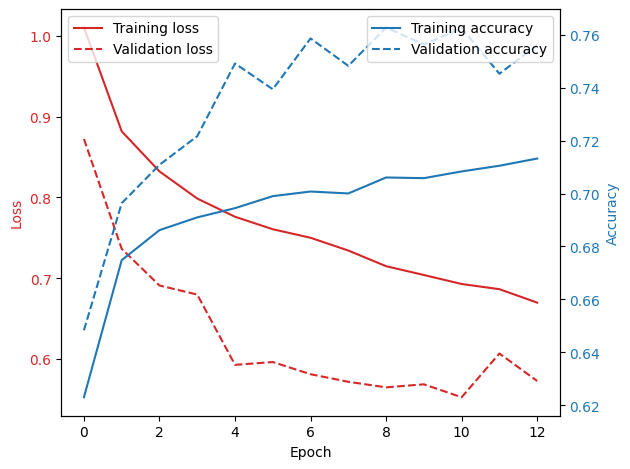

In [13]:
# Visualize training history
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.history['loss'], label='Training loss', color=color)
ax1.plot(history.history['val_loss'], label='Validation loss', linestyle='dashed', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history.history['accuracy'], label='Training accuracy', color=color)
ax2.plot(history.history['val_accuracy'], label='Validation accuracy', linestyle='dashed', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()

# Adding data augmentation
Increase existing dataset with additional 20% augmented images

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

def generate_augmented_data(X_train, y_train, augmentation_ratio, batch_size=32):
    # Create an ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=66,
        horizontal_flip=True,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        shear_range=0.2
    )

    # Calculate the number of augmented images to generate
    original_images_count = len(X_train)
    augmented_images_count = int(original_images_count * augmentation_ratio)

    # Generate augmented data
    augmented_data = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=False)

    # Iterate to accumulate augmented images
    X_augmented = []
    y_augmented = []
    for _ in range(augmented_images_count // batch_size):
        augmented_images, augmented_labels = augmented_data.next()
        X_augmented.append(augmented_images)
        y_augmented.append(augmented_labels)

    # Concatenate original and augmented data
    X_augmented = np.concatenate((X_train, np.concatenate(X_augmented)), axis=0)
    y_augmented = np.concatenate((y_train, np.concatenate(y_augmented)), axis=0)

    return X_augmented, y_augmented


augmentation_ratio = 0.2
X_augmented, y_augmented = generate_augmented_data(X_train, y_train, augmentation_ratio)
print(X_augmented.shape, y_augmented.shape)


(66058, 32, 32, 1) (66058, 2)


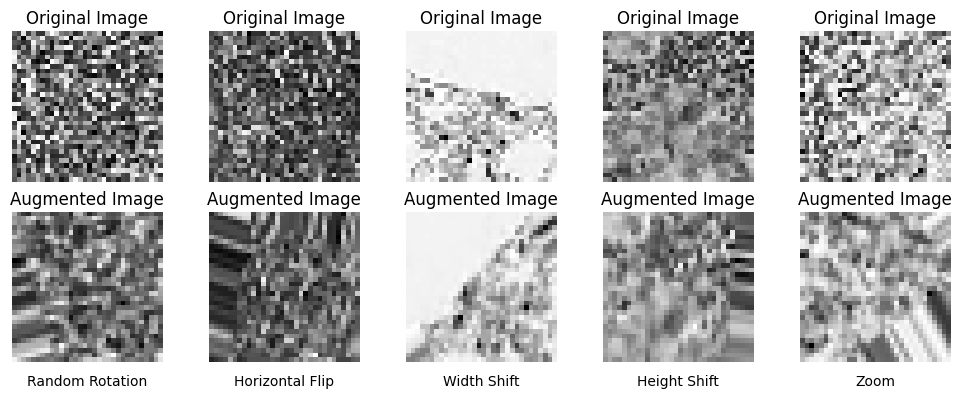

In [15]:
# Visualize a few original and augmented images
num_images_to_visualize = min(5, len(X_train))
fig, axes = plt.subplots(2, num_images_to_visualize, figsize=(2*num_images_to_visualize, 4))

# Define transformations for annotation
transformations = [
    "Random Rotation",
    "Horizontal Flip",
    "Width Shift",
    "Height Shift",
    "Zoom",
    "Shear"
]

for i in range(num_images_to_visualize):
    # Retrieve original and augmented images from the combined dataset
    original_image = X_augmented[i]
    augmented_image = X_augmented[i + len(X_train)]

    # Plot original and augmented images side by side
    axes[0, i].imshow(original_image.squeeze(), cmap='gray')
    axes[0, i].set_title("Original Image")
    axes[0, i].axis('off')  # Remove axes for the original images

    axes[1, i].imshow(augmented_image.squeeze(), cmap='gray')
    axes[1, i].set_title("Augmented Image")
    axes[1, i].axis('off')  # Remove axes for the augmented images

    # Annotate with transformation information below augmented images
    axes[1, i].text(0.5, -0.15, f'{transformations[i]}', size=10, ha='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.show()

# Train model with augmented images on validationset

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

# Train the model
aug_history = model.fit(
    X_augmented, y_augmented,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max")],
    epochs = 50
    )

Epoch 1/50
2065/2065 [==============================] - 16s 7ms/step - loss: 0.4349 - categorical_crossentropy: 0.4349 - accuracy: 0.8007 - val_loss: 1.1736 - val_categorical_crossentropy: 1.1736 - val_accuracy: 0.5243
Epoch 2/50
2065/2065 [==============================] - 15s 7ms/step - loss: 0.4298 - categorical_crossentropy: 0.4298 - accuracy: 0.8024 - val_loss: 0.5394 - val_categorical_crossentropy: 0.5394 - val_accuracy: 0.7653
Epoch 3/50
2065/2065 [==============================] - 15s 7ms/step - loss: 0.4284 - categorical_crossentropy: 0.4284 - accuracy: 0.8035 - val_loss: 0.4833 - val_categorical_crossentropy: 0.4833 - val_accuracy: 0.7869
Epoch 4/50
2065/2065 [==============================] - 15s 7ms/step - loss: 0.4259 - categorical_crossentropy: 0.4259 - accuracy: 0.8045 - val_loss: 0.5856 - val_categorical_crossentropy: 0.5856 - val_accuracy: 0.7156
Epoch 5/50
2065/2065 [==============================] - 15s 7ms/step - loss: 0.4257 - categorical_crossentropy: 0.4257 - acc

# Finally, predictions on the test set

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
precision, recall, f1, _ = precision_recall_fscore_support(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average='weighted')

# Print or use the metrics as needed
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


246/246 [==============================] - 1s 2ms/step
Accuracy: 79.16%
Precision: 0.7957
Recall: 0.7916
F1 Score: 0.7909
